In [1]:
import numpy as np
import pandas as pd
import os
import json
from matplotlib import pyplot as plt
import seaborn as sns
import pickle

In [2]:
RUN_PATH = '/mnt/ssd-1/sai/semantic-memorization/experiments/'

In [3]:
baseline_path = os.path.join(RUN_PATH, 'run-s1024-0-30', 'deduped', '12b')

In [4]:
baseline_taxonomies_path = os.path.join(baseline_path, 'model_taxonomy', "taxonomic_prediction_metrics.json")
with open(baseline_taxonomies_path, 'r') as f:
    data = json.load(f)
    
base_evals = {
    'taxonomy': [],
    'metric': [],
    'value': [],
    'model': [],
    'error': [],
}

for key, value in data.items():
    value, error = value
    if key.endswith('pr_curve'):
        continue
    try:
        model, taxonomy, metric, _ = key.split("_")
    except ValueError:
        model, taxonomy, metric = key.split("_")
    if model == 'model':
        model = 'taxonomic_model'
    base_evals['taxonomy'].append(taxonomy)
    base_evals['metric'].append(metric)
    base_evals['value'].append(value)
    base_evals['model'].append(model)
    base_evals['error'].append(error)
base_evals_pd = pd.DataFrame.from_dict(base_evals)

In [22]:
NameChanges = {
    'roc': 'ROC',
    'pr': 'PR',
    'ece': 'ECE',
    'optimal_taxonomic_model': 'Optimally Partitioned Model'
}
def setname(name):
    if not isinstance(name, str):
        return name
    if name in NameChanges:
        return NameChanges[name]
    else:
        return ' '.join(word.capitalize() for word in name.split('_'))

In [23]:
sns.set_theme(style="darkgrid")
sns.set_palette("colorblind")
sns.set_context("talk")

# set font to times new roman for plots

In [43]:

sns.set_style({'font.family':'serif', 'font.serif':'Times New Roman'})
metric_lims = {
    'ROC AUC': (0, 1),
    'PR AUC': (0, 1),
    'Precision': (0, 1),
    'Recall': (0, 1),
    'ECE': (0, 0.15),
    'F1': (0, 1)
}
def plot_taxonomy(taxonomy_evals, title="", palette=None):
    tax_evals = pd.DataFrame()
    for col in taxonomy_evals.columns:
        col_new = setname(col)
        tax_evals[col_new] = taxonomy_evals[col].apply(setname)

    max_plots = tax_evals['Metric'].nunique() - 1
    fig, axs = plt.subplots(1, max_plots, figsize=(20, 6), sharey=True)
    ax_idx = 0
    for metric in tax_evals['Metric'].unique():
        if metric == 'ROC':
            continue
        evals = tax_evals[tax_evals['Metric'] == metric]
        ax = sns.barplot(evals, y='Taxonomy', x='Value', hue='Model', ax=axs[ax_idx], legend=ax_idx == (max_plots - 1), palette=palette)

        err_points = []
        for index, bar in enumerate(ax.patches):
            bar.set_edgecolor('black')
            bar.set_linewidth(1)
            height = bar.get_width()
            if height == 0 and bar.get_y() == 0:
                continue
            err_points.append((height, bar.get_y() + bar.get_height()/2))

        err_points.sort(key=lambda x:x[1])
        # Errors need to be formatted in a special way, as seaborn does not like precomputed values
        errors = []
        for taxonomy in ['Recitation', 'Reconstruction', 'Recollection', 'Aggregate']:
            for m_type in ['Taxonomic Model', 'Baseline', 'Optimal Taxonomic Model']:
                err = evals[(evals['Taxonomy'] == taxonomy) & (evals['Model'] == m_type)]
                if len(err) != 0:
                    errors.append(err['Error'].iloc[0])
        for point, err in zip(err_points, errors):
            ax.errorbar(point[0], point[1], yerr=err, fmt='none', ecolor='black', capsize=5)
        if ax_idx == (max_plots - 1):
            sns.move_legend(ax, "upper right", bbox_to_anchor=(-0.15, -0.15), ncols=4, frameon=False, title=None)
        ax.set_xlabel('Score')
        if metric in ['ROC', 'PR']:
            metric += " AUC"
            ax.set_xlabel('Area Under Curve')
        if metric == 'ECE':
            ax.set_xlabel('Error')
        ax.set_ylabel("")
        ax.set_title(title + f"{metric}")
        ax.set_xlim(metric_lims[metric])
        ax_idx += 1
    plt.suptitle("Model Performance Evals", y=1)
    plt.tight_layout()
    plt.savefig(f'model_performance_evals.png', bbox_inches="tight")
    plt.show()

/tmp/ipykernel_2327849/1064605959.py:57: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


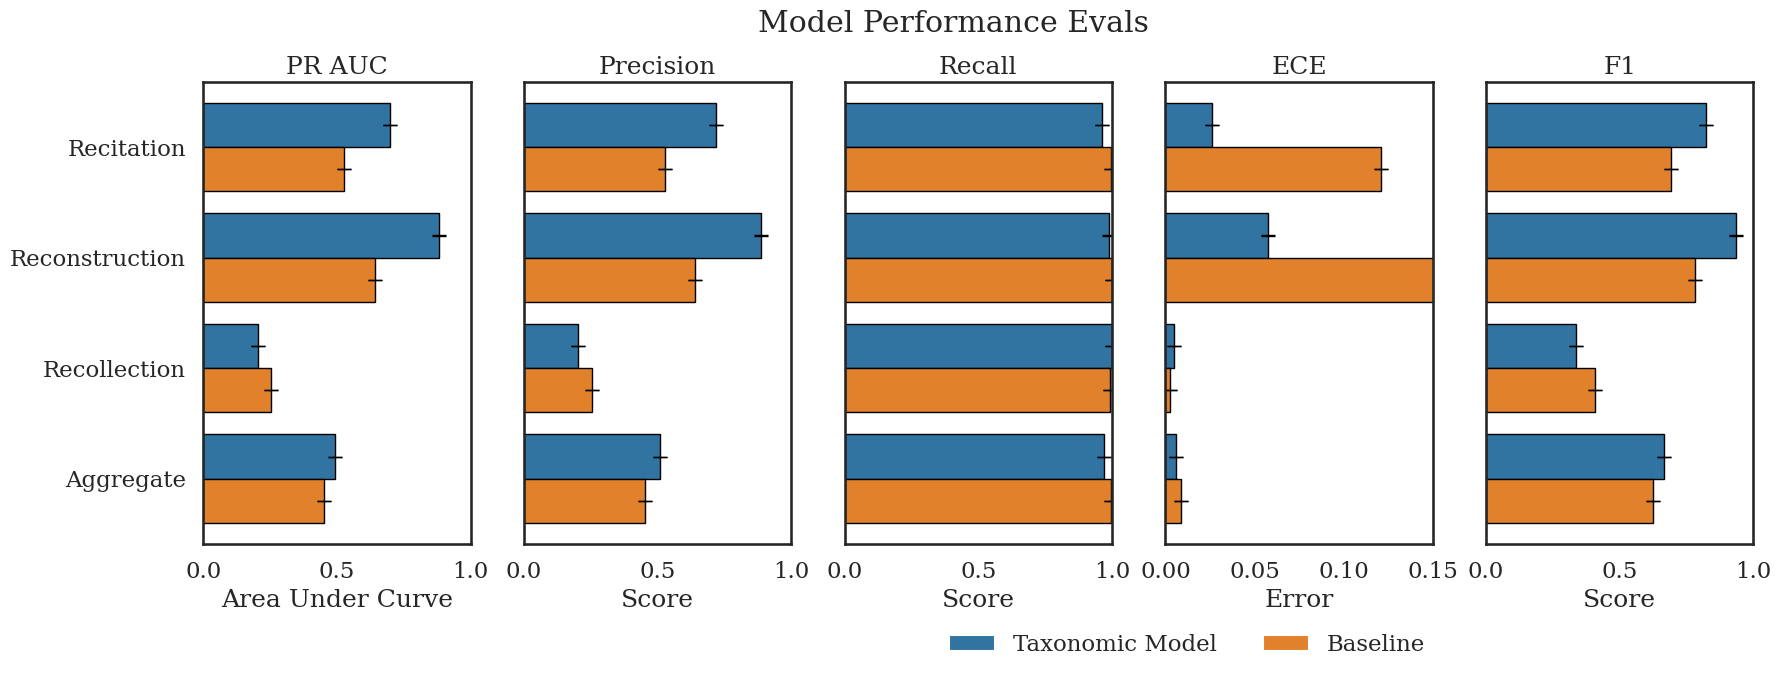

In [44]:
plot_taxonomy(base_evals_pd)

In [26]:
TAXONOMIES = ['recitation', 'reconstruction', 'recollection']

# Finding optimal taxonomy

In [27]:
from tqdm.auto import tqdm
opt_taxonomy_evals = {
    'taxonomy_one_name': [],
    'taxonomy_one_threshold': [],
    'taxonomy_two_name': [],
    'taxonomy_two_threshold': [],
    'taxonomy': [],
    'metric': [],
    'value': [],
    'model': [],
    'error': [],
}
for run in tqdm(os.listdir(RUN_PATH)):
    taxonomy_path = os.path.join(RUN_PATH, run, 'deduped', '12b', 'taxonomy_search')
    if not os.path.exists(taxonomy_path):
        continue
    for feature_one in os.listdir(taxonomy_path):
        for feature_two in os.listdir(os.path.join(taxonomy_path, feature_one)):
            meta_path = os.path.join(taxonomy_path, feature_one, feature_two, 'taxonomy_1', f'metadata.json')
            with open(meta_path, 'r') as f:
                metadata = json.load(f)
            f1, q1 = feature_one.split('-')
            q1 = float(q1)
            f2, q2 = feature_two.split('-')
            q2 = float(q2)
            data_path = os.path.join(taxonomy_path, feature_one, feature_two, 'taxonomic_prediction_metrics.json')
            with open(data_path, 'r') as f:
                data = json.load(f)
            for key, value in data.items():
                if key.endswith('pr_curve'):
                    continue
                try:
                    model, taxonomy, metric, _ = key.split("_")
                except ValueError:
                    model, taxonomy, metric = key.split("_")
                if model == 'model':
                    model = 'optimal_taxonomic_model'
                value, error = value
                opt_taxonomy_evals['taxonomy'].append(taxonomy)
                opt_taxonomy_evals['metric'].append(metric)
                opt_taxonomy_evals['value'].append(value)
                opt_taxonomy_evals['model'].append(model)
                opt_taxonomy_evals['taxonomy_one_name'].append(f1)
                opt_taxonomy_evals['taxonomy_one_threshold'].append(q1)
                opt_taxonomy_evals['taxonomy_two_name'].append(f2)
                opt_taxonomy_evals['taxonomy_two_threshold'].append(q2)
                opt_taxonomy_evals['error'].append(error)
                
opt_taxonomy_evals = pd.DataFrame.from_dict(opt_taxonomy_evals)

  0%|          | 0/29 [00:00<?, ?it/s]

In [28]:
from tqdm.auto import tqdm
tqdm.pandas()
import math

In [29]:
def set_f1(ds):
    def get_f1(x):
        precision = x.value
        precision_err = x.error
    
        features = {}
        for i in x.__dict__['_mgr'].__dict__['axes'][0]:
            if i not in ['metric', 'value', 'error']:
                features[i] = getattr(x, i)
    
        _recall_evals = recall_evals
        for (key, value) in features.items():
            _recall_evals = _recall_evals[_recall_evals[key] == value]
        assert(len(_recall_evals) == 1), _recall_evals.__repr__()
        recall = _recall_evals['value'].iloc[0]
        recall_err = _recall_evals['error'].iloc[0]
    
        f1_score = 2*(precision*recall)/(precision+recall)
        
        # ref: https://chatgpt.com/share/e93d04b7-8b8f-48a9-bcef-ddb5ce49df52
        f1_score_error = (2/(precision+recall)**2)*math.sqrt(recall**4*precision_err**2 + precision**4*recall_err**2)
        return f1_score, f1_score_error

    precision_evals = ds[ds['metric'] == 'precision']
    recall_evals = ds[ds['metric'] == 'recall']
    scores = precision_evals.progress_apply(get_f1, axis=1)
    precision_evals['value'] = scores.progress_apply(lambda x:x[0])
    precision_evals['error'] = scores.progress_apply(lambda x:x[1])
    
    precision_evals['metric'] = 'f1'
    return pd.concat([ds, precision_evals])

In [30]:
opt_taxonomy_evals = set_f1(opt_taxonomy_evals)
base_evals_pd = set_f1(base_evals_pd)

  0%|          | 0/2752 [00:00<?, ?it/s]

  0%|          | 0/2752 [00:00<?, ?it/s]

/tmp/ipykernel_2327849/2669423313.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  precision_evals['value'] = scores.progress_apply(lambda x:x[0])


  0%|          | 0/2752 [00:00<?, ?it/s]

/tmp/ipykernel_2327849/2669423313.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  precision_evals['error'] = scores.progress_apply(lambda x:x[1])
/tmp/ipykernel_2327849/2669423313.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  precision_evals['metric'] = 'f1'


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

In [31]:
best_eval = opt_taxonomy_evals[
    (opt_taxonomy_evals['taxonomy'] == 'aggregate') & 
    (opt_taxonomy_evals['model'] == 'optimal_taxonomic_model') &
    (opt_taxonomy_evals['metric'] == 'f1')
].sort_values('value', ascending=False).iloc[0]

In [32]:
best_eval

taxonomy_one_name           huffman_coding_length
taxonomy_one_threshold                       0.25
taxonomy_two_name             sequence_duplicates
taxonomy_two_threshold                       0.25
taxonomy                                aggregate
metric                                         f1
value                                    0.635575
model                     optimal_taxonomic_model
error                                    0.000289
Name: 12152, dtype: object

In [69]:
sns.set_theme(rc={'figure.figsize':(7, 16)})
sns.set_style({'font.family':'serif', 'font.serif':'Times New Roman'})
# sns.set_color_codes("colorblind")
sns.set_theme(style="white")
sns.set_context("talk")
sns.set_palette("muted")
def add_to_taxonomy_and_plot(f1, q1, f2, q2):
    data = opt_taxonomy_evals[
        (opt_taxonomy_evals['taxonomy_one_name'] == f1) &
        (opt_taxonomy_evals['taxonomy_two_name'] == f2) &
        (opt_taxonomy_evals['taxonomy_one_threshold'] == q1) &
        (opt_taxonomy_evals['taxonomy_two_threshold'] == q2)
    ]
    data = data[['taxonomy', 'metric', 'value', 'model', 'error']]
    data = data[data['model'] == 'optimal_taxonomic_model']
    opt_evals_pd = pd.concat([base_evals_pd, data])
    title = f"{f1}-{q1}  {f2}-{q2}\noptimal_"
    plot_taxonomy(opt_evals_pd, palette={
        'Taxonomic Model': '#d65f5f',
        'Baseline': '#956cb4',
        'Optimally Partitioned Model': '#8c613c'
    })

In [70]:
print(sns.color_palette("muted").as_hex())
sns.color_palette("muted")

['#4878d0', '#ee854a', '#6acc64', '#d65f5f', '#956cb4', '#8c613c', '#dc7ec0', '#797979', '#d5bb67', '#82c6e2']


[(0.2823529411764706, 0.47058823529411764, 0.8156862745098039),
 (0.9333333333333333, 0.5215686274509804, 0.2901960784313726),
 (0.41568627450980394, 0.8, 0.39215686274509803),
 (0.8392156862745098, 0.37254901960784315, 0.37254901960784315),
 (0.5843137254901961, 0.4235294117647059, 0.7058823529411765),
 (0.5490196078431373, 0.3803921568627451, 0.23529411764705882),
 (0.8627450980392157, 0.49411764705882355, 0.7529411764705882),
 (0.4745098039215686, 0.4745098039215686, 0.4745098039215686),
 (0.8352941176470589, 0.7333333333333333, 0.403921568627451),
 (0.5098039215686274, 0.7764705882352941, 0.8862745098039215)]

/tmp/ipykernel_2327849/1064605959.py:57: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


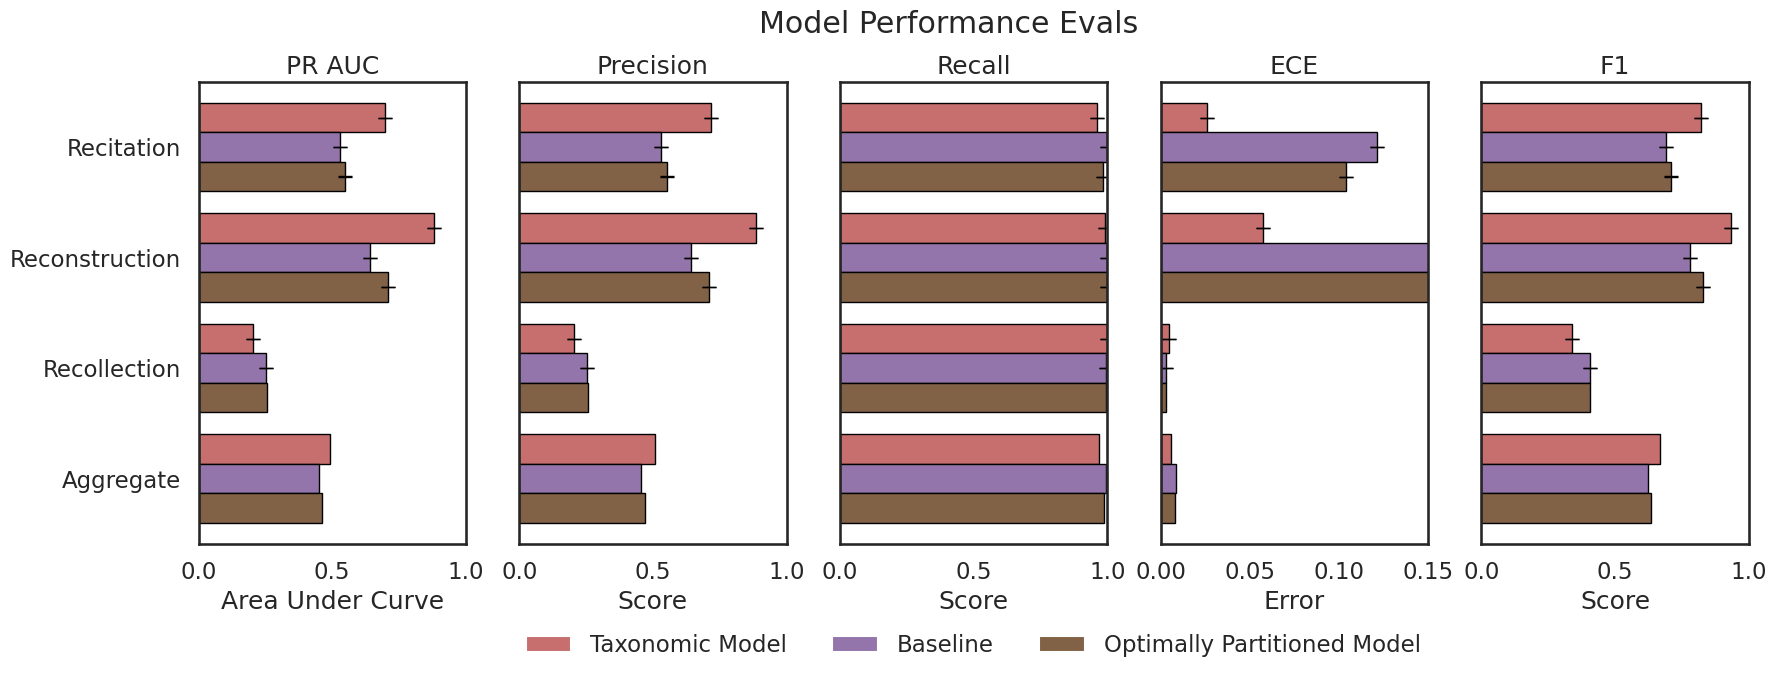

In [71]:
add_to_taxonomy_and_plot(best_eval.taxonomy_one_name, best_eval.taxonomy_one_threshold, best_eval.taxonomy_two_name, best_eval.taxonomy_two_threshold)

In [75]:
def plot_weights(model, title=""):
    data = pd.DataFrame({
        'weights': model.coef_[0],
        'features': model.feature_names_in_
    })
    new_data = pd.DataFrame()
    for col in data:
        new_col = setname(col)
        new_data[new_col] = data[col].apply(setname)
    sns.barplot(new_data, x='Weights', y='Features')
    plt.xscale('symlog')
    title = setname(title)
    plt.title(title)
    title = title.split("\n")[-1].replace(" ", "_")
    plt.savefig(f"{title}.png", bbox_inches="tight")
    plt.show()

In [76]:
import pickle
import sys
sys.path.append("..")

In [77]:
baseline_model_path = os.path.join(baseline_path, 'baseline', 'lr.pkl')

In [78]:
NameChanges = {
    'roc': 'ROC',
    'pr': 'PR',
    'ece': 'ECE',
    '0_8_templates': 'Textual Matches' ,
    '0_8_snowclones': 'Semantic Matches',
    'max_frequency': 'Max Token Freq',
    'min_frequency': 'Min Token Freq',
    'avg_frequency': 'Mean Token Freq',
    'median_frequency': 'Median Token Freq',
    'p25_frequency': 'P25 Token Freq',
    'p75_frequency': 'P75 Token Freq',
    'generation_perplexity': 'Continuation PPL',
    'prompt_perplexity': 'Prompt PPL',
    'sequence_perplexity': 'Sequence PPL',
    'sequence_duplicates': 'Duplicates',
    'huffman_coding_length': 'Huffman Length'
}

In [79]:
with open(baseline_model_path, 'rb') as f:
    baseline_model = pickle.load(f)
    model_weights = {
        'weights': baseline_model.coef_[0].tolist(),
        'features': baseline_model.feature_names_in_.tolist(),
        'model': ['baseline' for _ in range(len(baseline_model.feature_names_in_))],
    }

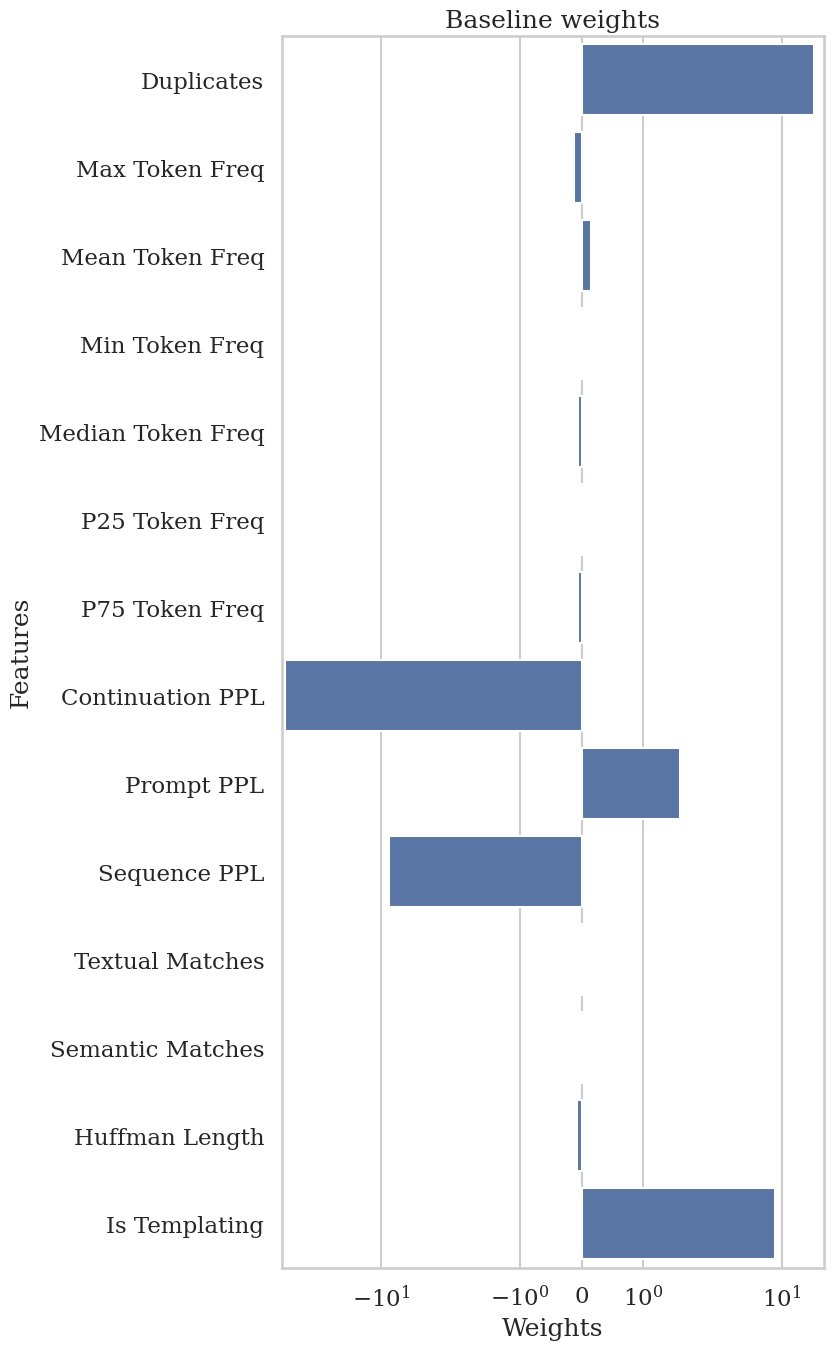

In [80]:
plot_weights(baseline_model, "baseline weights")

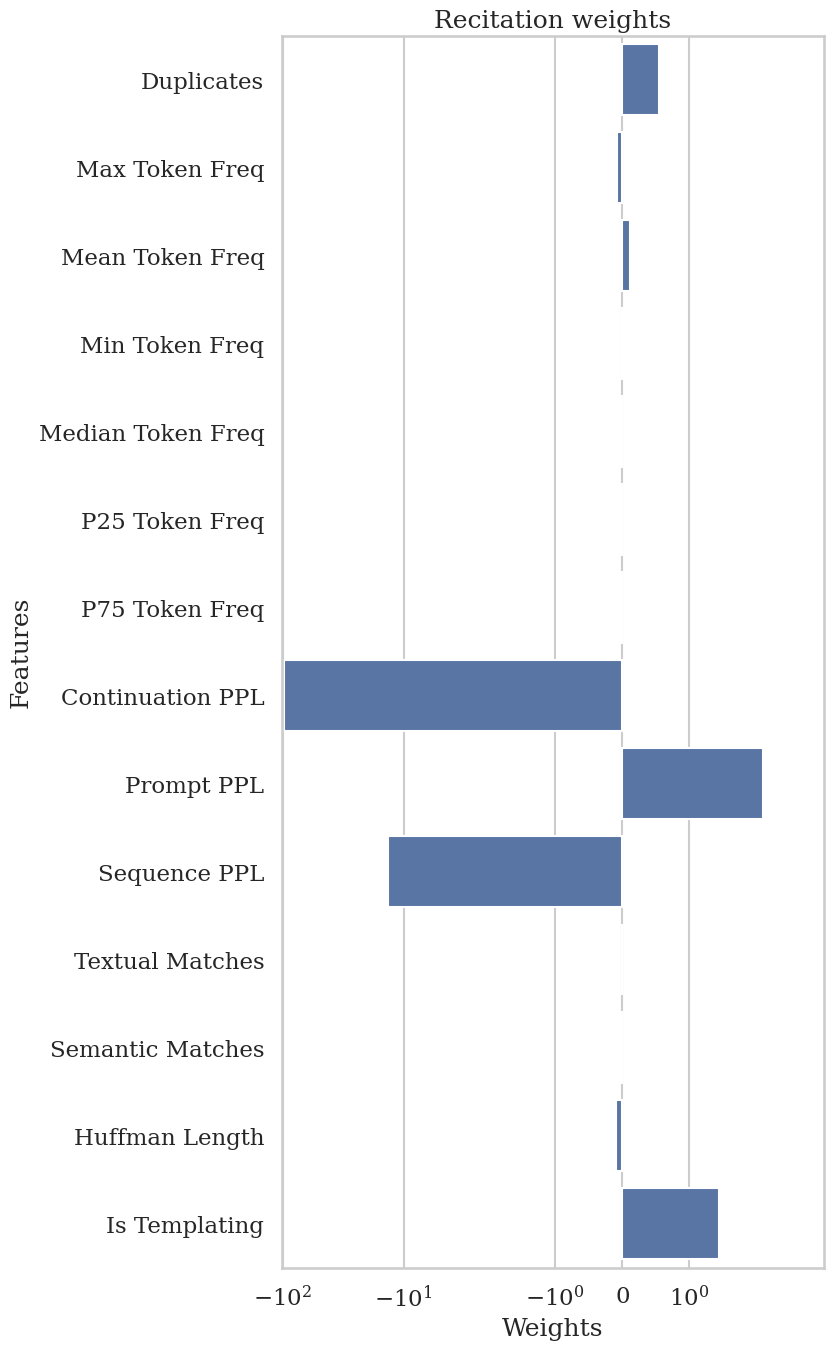

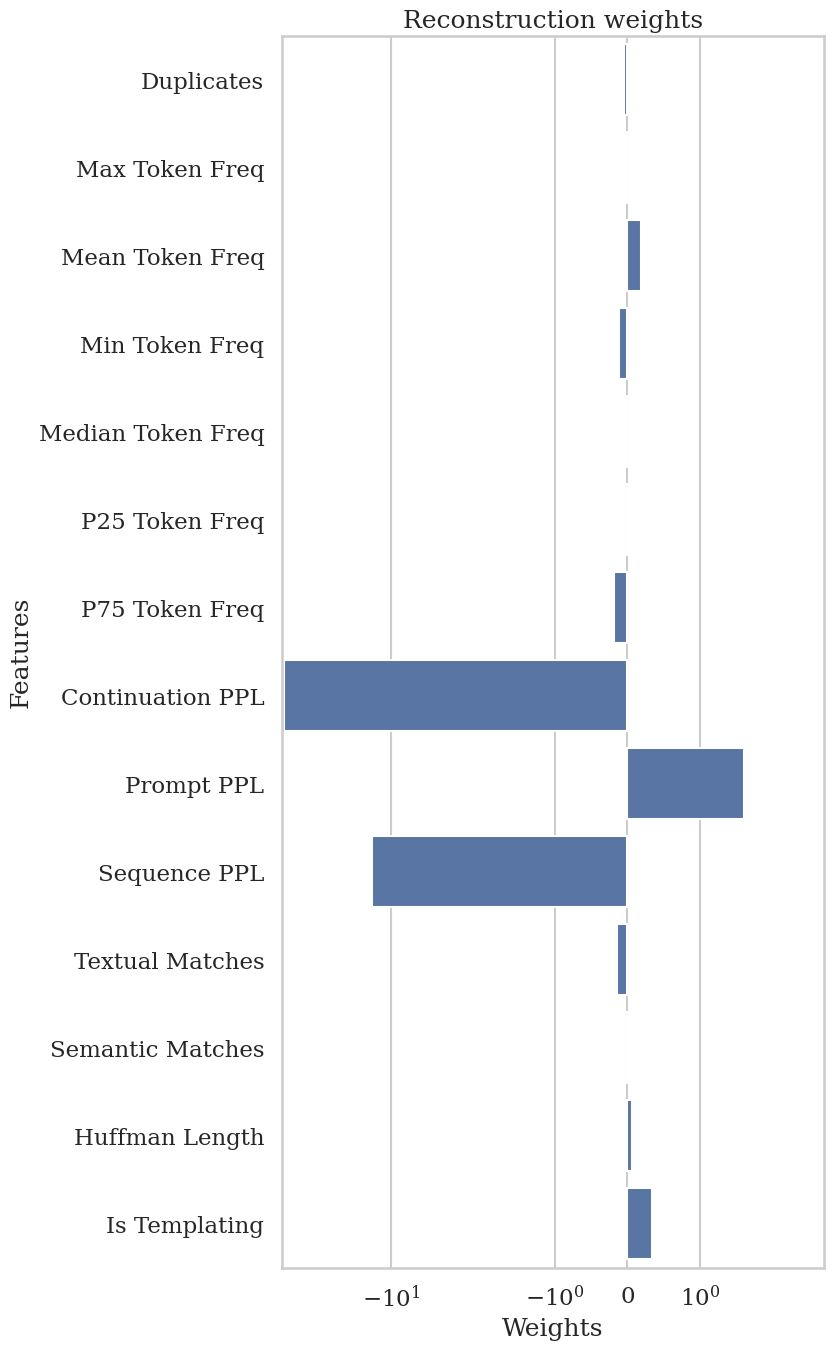

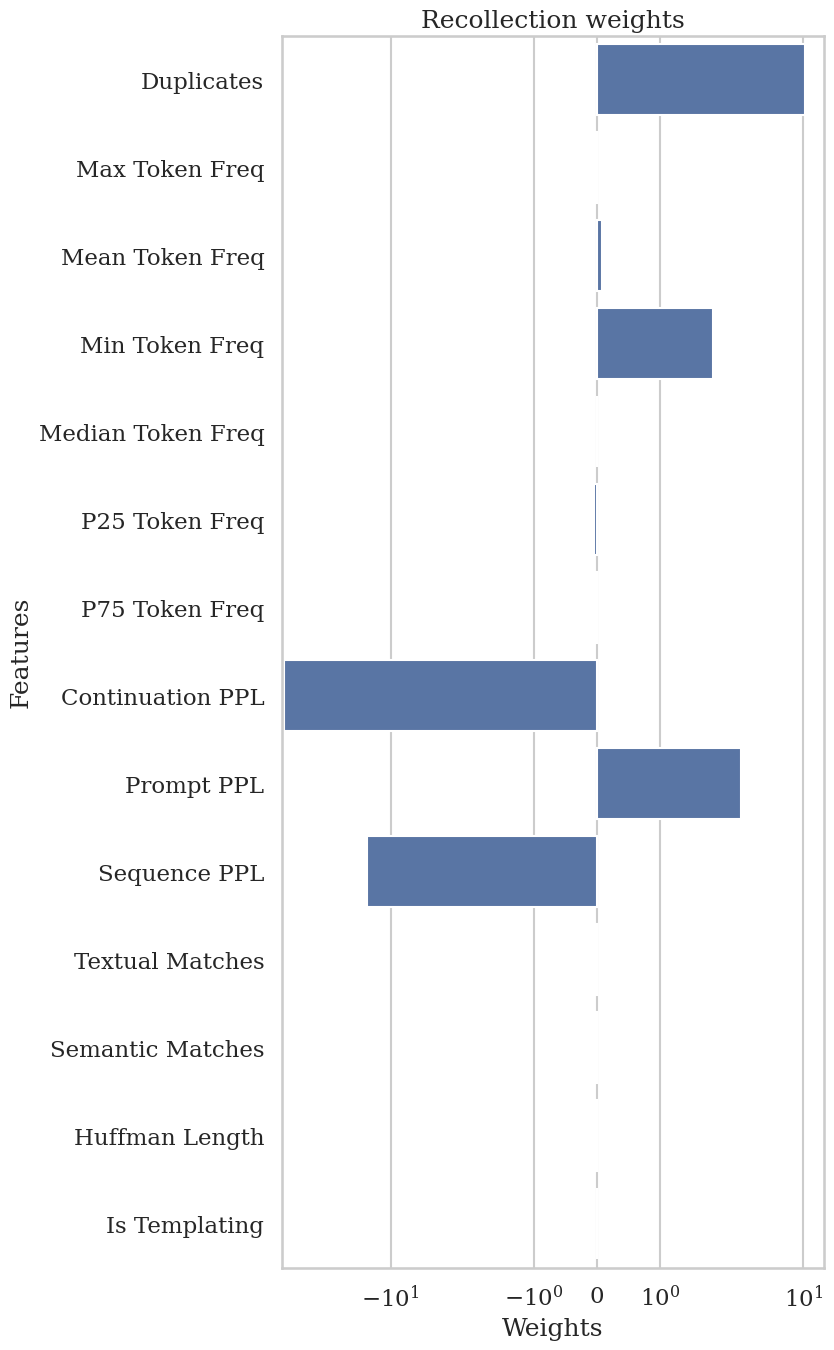

In [81]:
for taxonomy in ['recitation', 'reconstruction', 'recollection']:
    tax_model_path = os.path.join(baseline_path, 'model_taxonomy', taxonomy, 'lr.pkl')
    with open(tax_model_path, 'rb') as f:
        model = pickle.load(f)
        model_weights['weights'].extend(model.coef_[0].tolist())
        model_weights['features'].extend(model.feature_names_in_.tolist())
        model_weights['model'].extend([taxonomy for _ in range(len(model.feature_names_in_))])
    plot_weights(model, f'{taxonomy} weights')

In [82]:
EXTEND_OPT_TAX=False

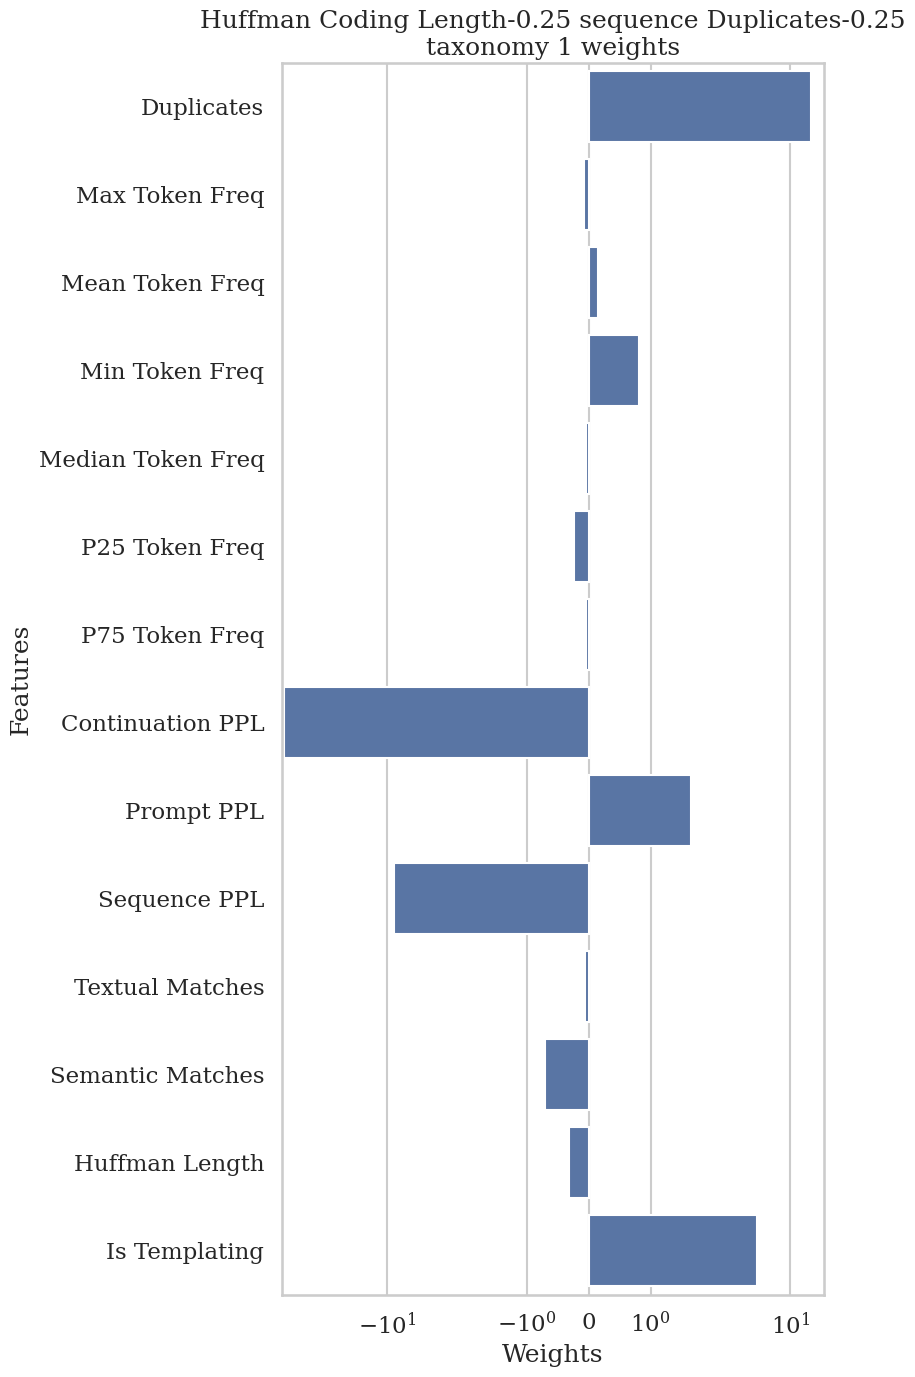

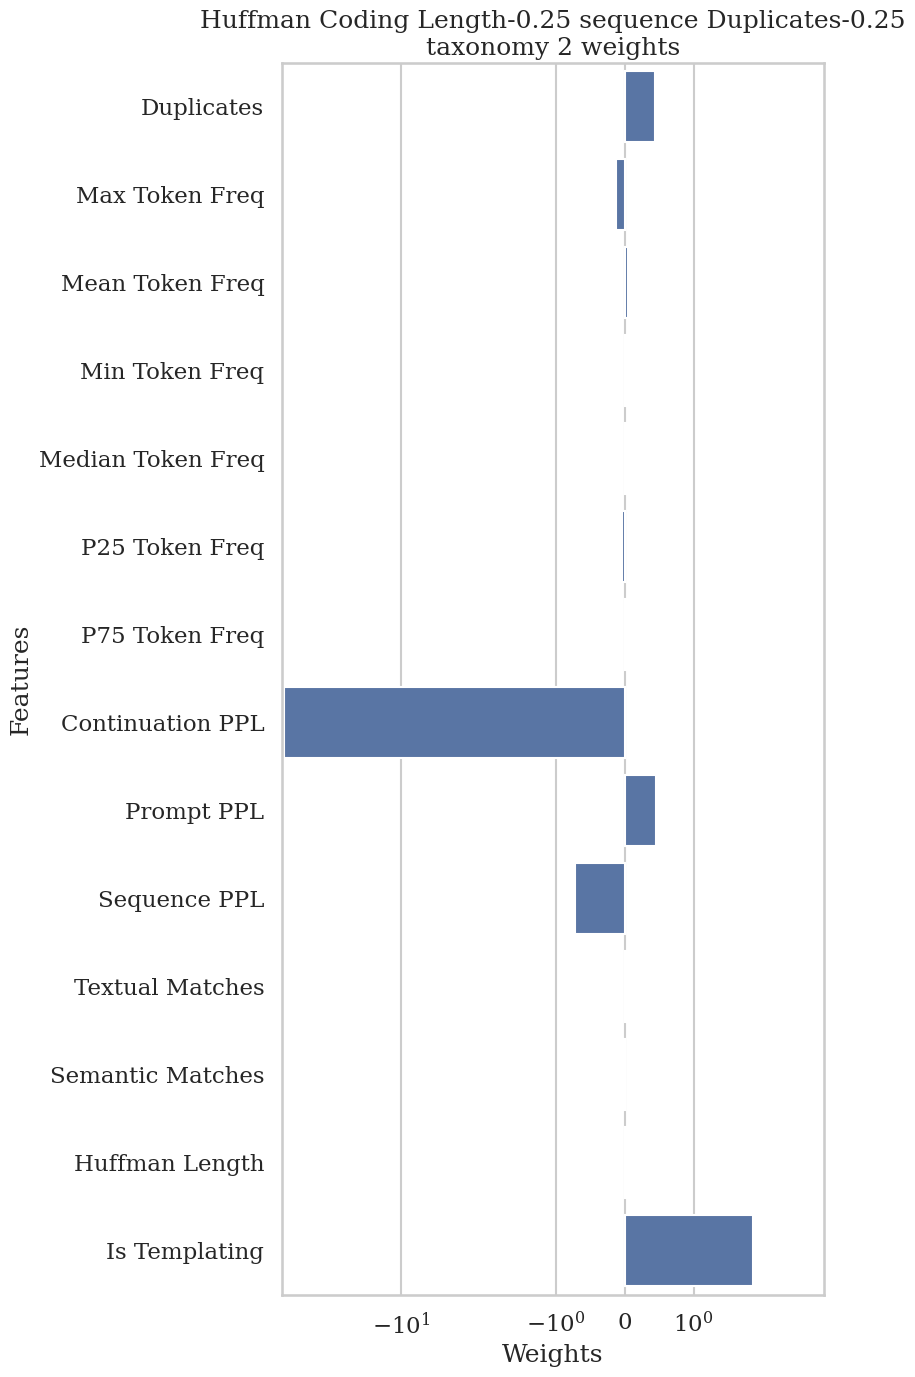

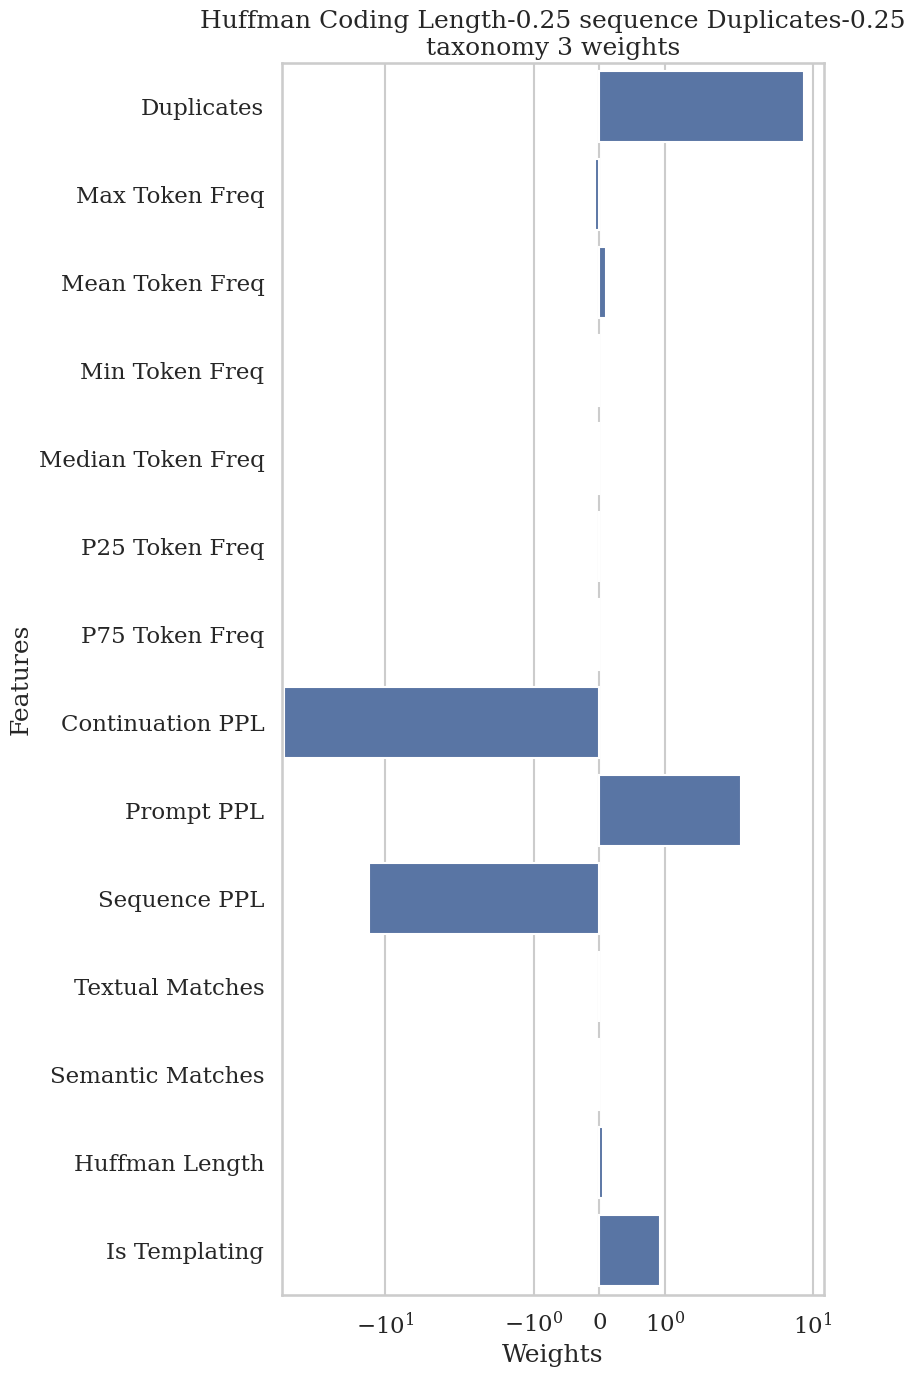

In [83]:
for run in os.listdir(RUN_PATH):
    taxonomy_path = os.path.join(RUN_PATH, run, 'deduped', '12b', 'taxonomy_search')
    if not os.path.exists(taxonomy_path):
        continue
    for feature_one in os.listdir(taxonomy_path):
        if feature_one != f'{best_eval.taxonomy_one_name}-{best_eval.taxonomy_one_threshold}':
            continue
        for feature_two in os.listdir(os.path.join(taxonomy_path, feature_one)):
            if feature_two != f'{best_eval.taxonomy_two_name}-{best_eval.taxonomy_two_threshold}':
                continue
            for taxonomy in ['taxonomy_1', 'taxonomy_2', 'taxonomy_3']:
                tax_model_path = os.path.join(taxonomy_path, feature_one, feature_two, taxonomy, 'lr.pkl')
                with open(tax_model_path, 'rb') as f:
                    model = pickle.load(f)
                    if EXTEND_OPT_TAX:
                        model_weights['weights'].extend(model.coef_[0].tolist())
                        model_weights['features'].extend(model.feature_names_in_.tolist())
                        model_weights['model'].extend([taxonomy for _ in range(len(model.feature_names_in_))])
                plot_weights(model, f'{feature_one} {feature_two}\n{taxonomy} weights') 

In [84]:
sns.set_theme(rc={'figure.figsize':(7, 16)})
sns.set_style({'font.family':'serif', 'font.serif':'Times New Roman'})
sns.set_color_codes("colorblind")
sns.set_theme(style="whitegrid")
sns.set_context("talk")
sns.color_palette()

# set font to times new roman for plots
sns.set_style({'font.family':'serif', 'font.serif':'Times New Roman'})
def plot_weights_combined(model_weights):
    model_weights = pd.DataFrame.from_dict(model_weights)
    order = ['sequence_duplicates', 'is_templating', '0_8_templates', '0_8_snowclones',
             'max_frequency', 'avg_frequency', 'min_frequency', 'median_frequency', 
             'p25_frequency', 'p75_frequency', 'huffman_coding_length',
             'generation_perplexity', 'prompt_perplexity', 'sequence_perplexity']
    order = [setname(i) for i in order]
    model_weights_new = pd.DataFrame()
    for col in model_weights.columns:
        model_weights_new[setname(col)] = model_weights[col].apply(setname)
    ax = sns.barplot(model_weights_new, x='Weights', y='Features', hue='Model', order=order, palette={
        'Baseline': '#956cb4',
        'Recitation': '#1f77b4',
        'Reconstruction': '#ff7f0e',
        'Recollection': '#2ca02c'
    })
    ax.set_ylabel("")
    ax.set_xlabel("Feature Weights")
    sns.move_legend(ax, "lower center", bbox_to_anchor=(0.3, -0.15), ncols=2, frameon=False, title=None)
    # plt.title("Model Weights")
    plt.xscale("symlog")
    # plt.xticks(rotation=90)
    plt.savefig("model_weights.png", bbox_inches="tight")

In [85]:
print(sns.color_palette("tab10").as_hex())
sns.color_palette("tab10")

['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']


[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

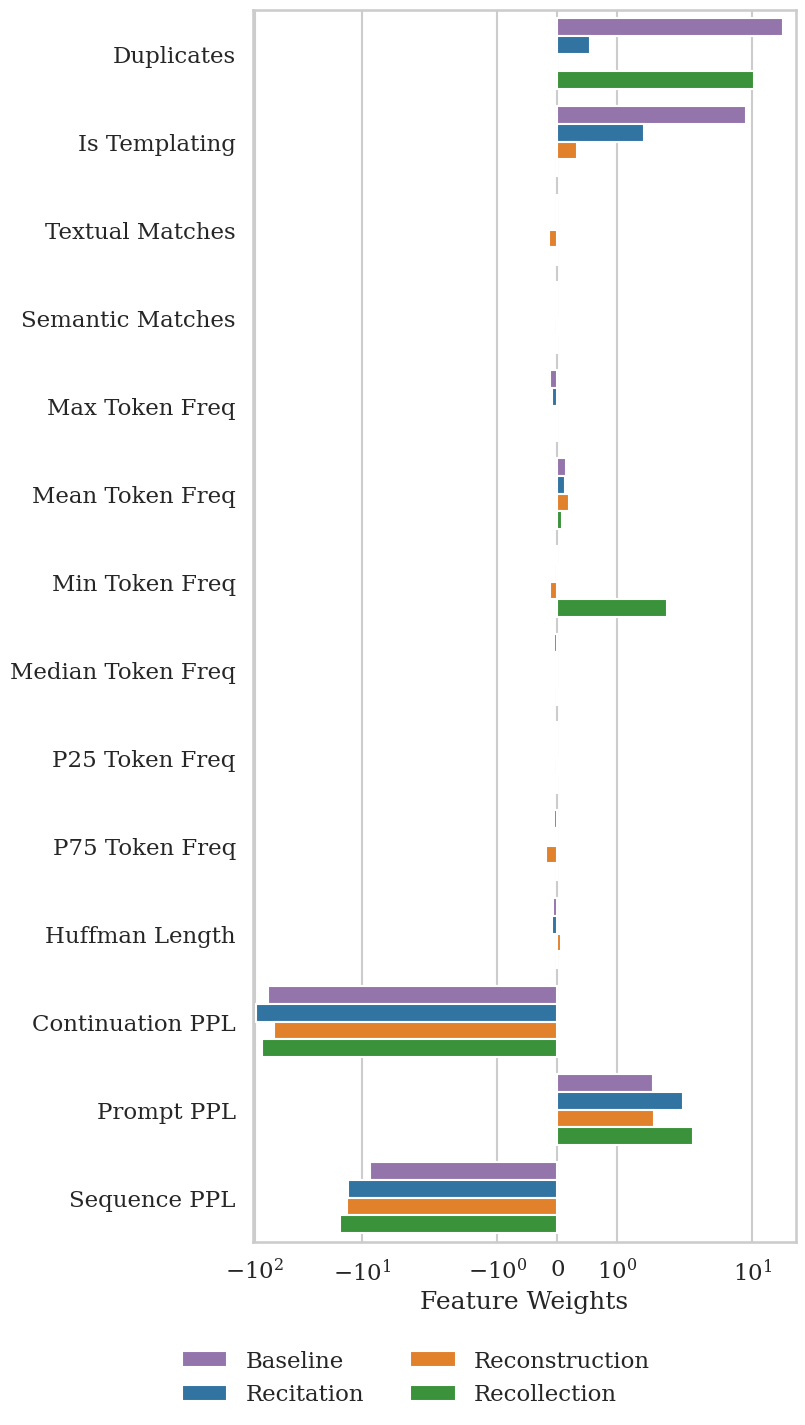

In [86]:
plot_weights_combined(model_weights)